# **Analysis of Occupational Fatalities Across U.S. Industries**
**Eunsoo Suk**

# **Table of Contents**

1. **Introduction**

2. **Data Collection**

3. **Data Cleaning**
   - 3.1 Initial inspection  
   - 3.2 Standardizing industry names  
   - 3.3 Converting accident-type columns  
   - 3.4 Recomputing total fatalities  
   - 3.5 Cleaning and imputing NAICS codes  
   - 3.6 Normalizing industry names and manual mapping  
   - 3.7 Removing summary rows and final dataset  

4. **Exploratory Data Analysis (EDA)**
   - 4.1 Dataset overview  
   - 4.2 Distribution of total fatalities  
   - 4.3 Yearly trend of total fatalities  
   - 4.4 Top industries by cumulative fatalities  
   - 4.5 Accident-type composition  
   - 4.6 Industry-year heatmap  
   - 4.7 NAICS-level analysis  

5. **Industry Clustering (Autoencoder + KMeans)**
   - 5.1 Feature aggregation  
   - 5.2 Scaling  
   - 5.3 Autoencoder architecture  
   - 5.4 Training the autoencoder  
   - 5.5 Latent embedding extraction  
   - 5.6 KMeans clustering  
   - 5.7 Descriptive cluster labels  
   - 5.8 Latent-space visualization  
   - 5.9 Cluster-level accident-type profiles  
   - 5.10 Representative industries  

6. **Fatal Injury Forecasting**
   - 6.1 Annual time-series preparation  
   - 6.2 Holt’s Linear Trend model  
   - 6.3 Visualization of Holt’s forecast  
   - 6.4 Linear Regression trend model  
   - 6.5 Forecast comparison  
   - 6.6 Interpretation of forecasting results  
   - 6.7 Accident-Type Forecasting (Multivariate Perspective)  

7. **Statistical Validation and Robustness Checks**
   - 7.1 Bootstrap confidence intervals  
   - 7.2 Levene’s test for variance shift  
   - 7.3 ANOVA across clusters  
   
8. **Clustering Robustness and Validation**
    - 8.1 Silhouette Score and Davies–Bouldin Index
    - 8.2 Hierarchical Clustering of Top 40 High-Fatality Industries

9. **Key Findings and Discussion**

10. **Limitations and Future Work**

11. **Policy Interpretation / Actionable Insights**

## **1. Introduction**

Understanding workplace fatalities is essential for identifying high-risk industries, improving safety standards, and informing future prevention strategies. Each year, the U.S. Bureau of Labor Statistics (BLS) publishes detailed fatal-injury tables that summarize how and where these incidents occur—categorized by industry, accident type, and year. Although these tables offer valuable insights, they are separated across multiple files and vary in format, terminology, and data quality. As a result, meaningful analysis requires careful integration and preprocessing before any conclusions can be drawn.

This project brings together nearly a decade of BLS fatal-injury data and transforms it into a unified, analyzable dataset. After cleaning inconsistencies in industry names, correcting missing or ambiguous NAICS codes, and standardizing accident-type counts, the data is used to explore major patterns in occupational fatalities. Through visualization, clustering, and trend analysis, the project highlights which industries are most affected by specific accident types and how conditions have changed over time.

In addition to descriptive analysis, the project incorporates forecasting models to estimate future fatal-injury trends for industries with sufficient historical data. By combining data engineering, statistical modeling, and machine-learning techniques, the study provides an interpretable, data-driven overview of workplace safety in the United States—offering insights that can support both research and real-world safety decision-making.

## **2. Data Collection**

The dataset used in this project comes from the **U.S. Bureau of Labor Statistics (BLS)**, specifically the **Census of Fatal Occupational Injuries (CFOI)** program.  
Each year, the BLS publishes a detailed table titled:

**“Table A-1. Fatal occupational injuries by industry and event or exposure”**

This table reports the total number of fatal workplace injuries across all major U.S. industries, broken down by accident types including:

- Transportation incidents  
- Violence and other injuries by persons or animals  
- Contact with objects and equipment  
- Falls, slips, and trips  
- Exposure to harmful substances or environments  
- Fires and explosions  

To conduct a consistent 10-year analysis, we collected and standardized **Table A-1 data for 2014–2023**, then merged all years into a single dataset ready for downstream analysis (trend analysis, clustering, and forecasting).


### **2.1 Source Files and Naming**

Most of the CFOI A-1 tables are provided directly as downloadable Excel workbooks on the BLS website, while the **2014** table is only available as a **PDF**.  
To ensure consistency across all years, we harmonized these formats into a single standardized structure.

#### **Excel files (2015–2023)**

On the BLS website, each yearly table appears under titles such as:

- *“Industry by event or exposure, 2022 (XLSX)”*  
- *“Industry by event or exposure, 2021 (XLSX)”*  

When downloaded, these files follow a consistent standardized naming pattern:

- `fatal-occupational-injuries-table-a-1-2014.pdf`  
- `fatal-occupational-injuries-table-a-1-2015.xlsx`  
- `fatal-occupational-injuries-table-a-1-2016.xlsx`  
- …  
- `fatal-occupational-injuries-table-a-1-2023.xlsx`  

These Excel tables share a common layout and can be loaded directly using `pandas.read_excel()`.

#### **PDF file (2014)**

The **2014** A-1 table is distributed only as a PDF (`fatal-occupational-injuries-table-a-1-2014.pdf`).  
To maintain a fully reproducible workflow, the PDF was parsed programmatically and converted into a dataframe with the same schema as the Excel files.

#### **Data sources**

All files were obtained from the official BLS CFOI database:

https://www.bls.gov/iif/fatal-injuries-tables.htm  
https://www.bls.gov/iif/fatal-injuries-tables/archive.htm#RATES

#### **Unified directory**

All downloaded files (2014 PDF + 2015–2023 Excel workbooks) were stored in a **single directory**, enabling a unified loading loop that iterates through years and builds a fully consolidated dataset.


### **2.2 Parsing the 2014 PDF**

Because the 2014 table is only available as a PDF, we implemented a small line-level parser using `pdfplumber` and regular expressions:

1. Read each page of the PDF and split it into text lines.  
2. For each line, detect whether it represents a valid industry row by checking:
   - the last seven tokens are numeric (or `--`) and correspond to accident-type counts,  
   - the remaining tokens contain the industry name and, optionally, a NAICS code.
3. Split the line into:
   - `Industry` name,  
   - `NAICS code` (when present),  
   - seven accident-type values.  
4. Assemble these into a dictionary and collect them as rows in a dataframe.

This produces a 2014 dataframe that already matches the **standard column layout** used for the later Excel files.


In [1]:
import pdfplumber
import pandas as pd
import re
from pathlib import Path

# ---------- 2014 line-level parser ----------
def parse_cfoi_line(line: str):
    """Parse one text line from the A-1 PDF into a dict, or return None."""
    line = line.strip()
    if not line:
        return None

    tokens = line.split()
    if len(tokens) < 8:
        return None

    # Last 7 tokens must be numbers with optional commas or '--'
    numeric_pattern = re.compile(r'^(?:\d{1,3}(?:,\d{3})*|--)$')
    event_tokens = tokens[-7:]
    if not all(numeric_pattern.match(t) for t in event_tokens):
        return None

    # Remaining tokens: Industry name + optional NAICS code
    pre = tokens[:-7]
    if not pre:
        return None

    naics = None
    cand = pre[-1]
    # NAICS: digits and '-' only (e.g., 23, 31-33, 11115)
    if re.match(r'^[0-9][0-9\-]*$', cand) and ',' not in cand:
        naics = cand
        industry_tokens = pre[:-1]
    else:
        industry_tokens = pre

    industry = " ".join(industry_tokens).strip()
    if not industry:
        return None

    total, v_other, transport, fires, falls, exposure, contact = event_tokens

    return {
        "Industry": industry,
        "NAICS code": naics,
        "Total fatal injuries": total,
        "Violence and other injuries by persons or animals": v_other,
        "Transportation incidents": transport,
        "Fires and explosions": fires,
        "Falls, slips, trips": falls,
        "Exposure to harmful substances or environments": exposure,
        "Contact with object and equipment": contact,
    }


def pdf_2014_to_df(pdf_path: Path) -> pd.DataFrame:
    """Convert the 2014 A-1 PDF into a dataframe."""
    records = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if not text:
                continue
            for line in text.splitlines():
                rec = parse_cfoi_line(line)
                if rec:
                    records.append(rec)
    return pd.DataFrame(records)


### **2.3 Standard Table Schema and Basic Cleaning**

To be able to merge all years into a single dataset, we enforce a common column schema and apply a small amount of structural cleaning.

#### **Standard column order**

We define a fixed column order that is used across all years:

- `Industry`  
- `NAICS code`  
- `Total fatal injuries`  
- `Violence and other injuries by persons or animals`  
- `Transportation incidents`  
- `Fires and explosions`  
- `Falls, slips, trips`  
- `Exposure to harmful substances or environments`  
- `Contact with object and equipment`  

#### **Removing non-data rows**

The original tables include footnotes, notes, and source lines (e.g., “Footnotes”, “Source: U.S. Department of Labor”, or rows starting with `(1)`).  
These are removed using a simple text filter which checks the `Industry` column and drops rows that correspond to notes rather than actual industries.

#### **Minimal cleaning steps**

For each year’s table we:

1. Force column names to match the standard schema (truncating if necessary).  
2. Drop rows that are completely empty.  
3. Remove footnotes / notes / header explanation rows.  
4. Keep only rows where `Industry` is a valid string and strip extra spaces.  
5. Drop exact duplicate rows.  

The helper functions below implement this logic.


In [2]:
# Standard column order used for all years
standard_cols = [
    "Industry",
    "NAICS code",
    "Total fatal injuries",
    "Violence and other injuries by persons or animals",
    "Transportation incidents",
    "Fires and explosions",
    "Falls, slips, trips",
    "Exposure to harmful substances or environments",
    "Contact with object and equipment",
]

# Keywords that indicate footnote / note / source rows
footnote_keywords = [
    "Footnotes", "Note:", "Source:", "CFOI",
    "Includes", "U.S. Department", "Dashes indicate",
]

def is_footnote_row(text):
    """Return True if a row in the Industry column is a footnote or note."""
    if pd.isna(text):
        return False
    s = str(text).strip()
    # Patterns like "(1)", "(2)", ...
    if re.match(r"^\(\d+\)", s):
        return True
    return any(k in s for k in footnote_keywords)


def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    """Apply minimal structural cleaning to one year's table."""
    # Force consistent column names 
    df.columns = standard_cols[:len(df.columns)]

    # Drop rows that are completely empty
    df = df.dropna(how="all")

    # Remove footnotes / notes / source rows
    df = df[~df["Industry"].apply(is_footnote_row)]

    # Remove header-explanation rows like "Industry(1)"
    mask_header = df["Industry"].astype(str).str.match(r"\s*Industry\s*\(\d+\)")
    df = df[~mask_header]

    # Keep only rows where Industry is a string, strip extra spaces
    df = df[df["Industry"].apply(lambda x: isinstance(x, str))]
    df["Industry"] = df["Industry"].str.strip()

    # Remove exact duplicate rows
    df = df.drop_duplicates()

    return df


### **2.4 Loading and Merging All Years (2014–2023)**

Before loading the datasets, the notebook automatically downloads all A-1 tables directly from the BLS website.  
To ensure full reproducibility on any machine, the script first detects the user’s Desktop directory dynamically:

```python
from pathlib import Path

desktop_dir = Path.home() / "Desktop"
save_dir = desktop_dir / "Data"
```

Once all files have been downloaded, we load and merge them into a unified dataframe:

1. Identify the directory containing yearly A-1 files (~/Desktop/Data).
2. 2014: parse the PDF version using pdf_2014_to_df().
3. 2015–2023: read Excel versions using pandas.read_excel().
4. Normalize raw column names (trim and collapse whitespace).
5. Apply a common cleaning function clean_df() to each table.
6. Append a Year column to every dataframe.
7. Concatenate all annual tables into a single dataset df_raw.

The final merged dataframe contains standardized columns and one row per industry–year combination, enabling consistent multi-year analysis of occupational fatalities.


In [3]:
from pathlib import Path
import os
import requests

# --- Detect user's Desktop folder automatically ---
desktop_dir = Path.home() / "Desktop"
save_dir = desktop_dir / "Data"
os.makedirs(save_dir, exist_ok=True)

# List of files to download (2014–2023)
urls = [
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2014.pdf",
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2015.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2016.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2017.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2018.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2019.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2020.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/archive/fatal-occupational-injuries-table-a-1-2021.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/fatal-occupational-injuries-table-a-1-2022.xlsx",
    "https://www.bls.gov/iif/fatal-injuries-tables/fatal-occupational-injuries-table-a-1-2023.xlsx",
]

# User-Agent to bypass 403 Forbidden
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

# Download files using original filename
for url in urls:
    filename = os.path.basename(url)
    save_path = os.path.join("Data", filename)

    if os.path.exists(save_path):
        print(f"Already exists: {save_path}")
        continue

    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        print(f"Failed ({r.status_code}): {url}")
        continue

    with open(save_path, "wb") as f:
        f.write(r.content)

    print(f"Saved: {save_path}")


Saved: Data\fatal-occupational-injuries-table-a-1-2014.pdf
Saved: Data\fatal-occupational-injuries-table-a-1-2015.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2016.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2017.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2018.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2019.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2020.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2021.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2022.xlsx
Saved: Data\fatal-occupational-injuries-table-a-1-2023.xlsx


In [4]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path.home() / "Desktop" / "Data"

pdf_2014_path = DATA_DIR / "fatal-occupational-injuries-table-a-1-2014.pdf"
years = range(2014, 2024)

all_dfs = []

for year in years:
    print(f"\n==== Loading {year} ====")

    if year == 2014:
        # 2014 is only available as PDF → parse with pdfplumber
        df_year = pdf_2014_to_df(pdf_2014_path)
    else:
        # 2015–2023: directly load Excel files
        excel_path = DATA_DIR / f"fatal-occupational-injuries-table-a-1-{year}.xlsx"
        df_year = pd.read_excel(excel_path)

        # Normalize raw column names (strip, collapse whitespace)
        df_year.columns = (
            df_year.columns
            .str.strip()
            .str.replace(r"\s+", " ", regex=True)
        )

    df_year = clean_df(df_year)

    df_year["Year"] = year

    all_dfs.append(df_year)

# Concatenate all years into a single raw dataset
df_raw = pd.concat(all_dfs, ignore_index=True)

print("\n=== Final df_raw ===")
print(df_raw.shape)
df_raw.head()
df_raw.info()



==== Loading 2014 ====

==== Loading 2015 ====

==== Loading 2016 ====

==== Loading 2017 ====

==== Loading 2018 ====

==== Loading 2019 ====

==== Loading 2020 ====

==== Loading 2021 ====

==== Loading 2022 ====

==== Loading 2023 ====

=== Final df_raw ===
(8494, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Industry                                           8494 non-null   object
 1   NAICS code                                         7846 non-null   object
 2   Total fatal injuries                               8494 non-null   object
 3   Violence and other injuries by persons or animals  8494 non-null   object
 4   Transportation incidents                           8492 non-null   object
 5   Fires and explosions                               8492 non-nu

### **Summary**

After running the pipeline above:

- All **10 years (2014–2023)** of Table A-1 data are combined into a single dataframe `df_raw`.  
- The 2014 PDF is parsed into the **same column layout** as the Excel years.  
- Non-data rows such as footnotes and notes are removed.  
- Each record includes:
  - `Industry`,  
  - `NAICS code`,  
  - total fatal injuries,  
  - seven accident-type counts,  
  - and the corresponding `Year`.

This cleaned, unified dataset forms the basis for the subsequent analyses:
- NAICS-level trend analysis,  
- accident-type distributions,  
- industry clustering, and  
- time-series forecasting of fatal injuries.


## **3. Data Cleaning**

This section describes the full cleaning pipeline applied to the raw dataset
after merging all yearly A-1 tables. The cleaning process includes:

- Standardizing text fields (e.g., Industry)
- Converting accident-type columns to numeric
- Recomputing totals where needed
- Cleaning and imputing NAICS codes
- Removing summary rows and zero-fatality entries

The final cleaned dataset is stored as `df_clean`.


In [5]:
import re
import numpy as np
import pandas as pd

df = df_raw.copy()

### **3.2 Clean Industry Names (whitespace, line breaks, special spaces)**

Industry names often contain non-breaking spaces, inconsistent whitespace,
or line breaks.<br> These issues prevent proper grouping and merging across years.<br>
We apply a text-normalization function to standardize all names.


In [6]:
def clean_text(s):
    """Remove non-breaking spaces, line breaks, and collapse multiple spaces."""
    if pd.isna(s):
        return s
    s = str(s)
    s = s.replace("\xa0", " ")                  # Remove non-breaking space
    s = re.sub(r"\s+", " ", s)                  # Collapse multiple spaces
    return s.strip()

df["Industry"] = df["Industry"].apply(clean_text)
df["Industry"].head()

0                                         Total
1                              Private industry
2                               Goods producing
3                  Natural resources and mining
4    Agriculture, forestry, fishing and hunting
Name: Industry, dtype: object

### **3.3 Converting accident-type columns to numeric values**

Accident-type fields sometimes contain placeholders such as “--” or include
comma formatting.<br> We convert all injury fields to numeric and drop rows
where all numeric components are missing.

In [7]:
# Accident-type columns exactly as in the dataset
cols_accident = [
    "Violence and other injuries by persons or animals",
    "Transportation incidents",
    "Fires and explosions",
    "Falls, slips, trips",
    "Exposure to harmful substances or environments",
    "Contact with object and equipment",
]

total_col = "Total fatal injuries"

# Convert columns to numeric
for col in cols_accident + [total_col]:
    df[col] = (
        df[col]
        .replace("--", np.nan)
        .astype(str)
        .str.replace(",", "", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows where all numeric fields are missing
numeric_cols = cols_accident + [total_col]
df = df.dropna(subset=numeric_cols, how="all").reset_index(drop=True)

df[numeric_cols].describe()


,Violence and other injuries by persons or animals,Transportation incidents,Fires and explosions,"Falls, slips, trips",Exposure to harmful substances or environments,Contact with object and equipment,Total fatal injuries
count,2544.000000,4023.000000,705.000000,2012.000000,1915.000000,2063.000000,8251.000000
mean,19.806997,33.896346,7.921986,25.232604,19.464230,22.348037,43.753484
std,71.022414,155.126520,17.395659,91.809174,67.682222,78.163939,268.812910
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,3.000000,1.000000,3.000000,3.000000,3.000000,3.000000
50%,5.000000,6.000000,3.000000,5.000000,5.000000,5.000000,7.000000
75%,14.000000,17.000000,7.000000,12.000000,12.000000,13.000000,19.000000
max,866.000000,2122.000000,137.000000,887.000000,839.000000,786.000000,5486.000000


### **3.4 Recomputing and validating total fatalities**

Some rows contain totals that do not match the sum of accident-type components.<br>
We recompute the total values and replace inconsistent entries.<br>
We also remove rows where total fatalities are zero.<br>

In [8]:
# Recompute totals from accident-type columns
df["total_calc"] = df[cols_accident].sum(axis=1, min_count=1)

# Replace totals where they are missing or inconsistent
mask_fix = df[total_col].isna() | (df[total_col] != df["total_calc"])
df.loc[mask_fix, total_col] = df.loc[mask_fix, "total_calc"]

# Remove temporary column
df = df.drop(columns=["total_calc"])

# Remove rows with zero fatalities
df = df[df[total_col] != 0].reset_index(drop=True)

df[total_col].describe()


count    6165.000000
mean       52.957826
std       307.631027
min         1.000000
25%         3.000000
50%         6.000000
75%        23.000000
max      5464.000000
Name: Total fatal injuries, dtype: float64

### **3.5 Cleaning NAICS codes and filling missing values**

The NAICS field contains missing values and inconsistent formatting
(e.g., decimals like "92216.0").<br> We standardize the formatting and fill
missing NAICS codes using the most common code for each Industry.<br>


In [9]:
def clean_naics(x):
    """Normalize NAICS codes: strip whitespace, remove decimals, convert blanks to NaN."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return np.nan
    if "." in s:                # Example: "92216.0" → "92216"
        s = s.split(".")[0]
    return s

# Step 1: clean raw NAICS values
df["NAICS code"] = df["NAICS code"].apply(clean_naics)

# Step 2: fill missing NAICS using most frequent code for each Industry
name_to_naics = (
    df[df["NAICS code"].notna()]
    .groupby("Industry")["NAICS code"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

mask_na = df["NAICS code"].isna()
df.loc[mask_na, "NAICS code"] = df.loc[mask_na, "Industry"].map(name_to_naics)

print("Missing NAICS after Industry-based fill:", df["NAICS code"].isna().sum())


Missing NAICS after Industry-based fill: 561


### **3.6 Normalizing Industry names and applying high-level NAICS mapping**

For some broad industry categories, NAICS codes are not included in the A-1 tables.<br>
We normalize Industry names (letters only, lowercase) and apply a manual mapping
to fill high-level groups.


In [10]:
# Normalize industry names to remove punctuation and standardize comparisons
def normalize_industry(x):
    if pd.isna(x):
        return x
    s = str(x).lower().strip()            # trim whitespace
    s = re.sub(r"[^a-z ]+", "", s)        # Keep only letters and spaces
    s = re.sub(r"\s+", " ", s).strip()    # Collapse spaces, strip again
    return s

df["Industry_norm"] = df["Industry"].apply(normalize_industry)


# Manual NAICS mapping for high-level industries
naics_map = {
    "accommodation and food services": "72",
    "administrative and support and waste management and remediation services": "56",
    "administrative and waste services": "56",
    "agriculture forestry fishing and hunting": "11",
    "arts entertainment and recreation": "71",
    "construction": "23",
    "educational and health services": "61",
    "federal government": "92",
    "finance and insurance": "52",
    "financial activities": "52",
    "goods producing": None,
    "government": "92",
    "health care and social assistance": "62",
    "information": "51",
    "leisure and hospitality": "71",
    "local government": "92",
    "manufacturing": "31-33",
    "mining": "21",
    "mining quarrying and oil and gas extraction": "21",
    "natural resources and mining": "11",
    "other services except public administration": "81",
    "private industry": None,
    "professional and business services": "54",
    "professional and technical services": "54",
    "public administration": "92",
    "real estate and rental and leasing": "53",
    "retail trade": "44-45",
    "service providing": None,
    "state government": "92",
    "trade transportation and utilities": "00",
    "transportation and warehousing": "48-49",
    "wholesale trade": "42",
}

mask_na2 = df["NAICS code"].isna()
df.loc[mask_na2, "NAICS code"] = df.loc[mask_na2, "Industry_norm"].map(naics_map)

print("Remaining NAICS missing:", df["NAICS code"].isna().sum())


Remaining NAICS missing: 58


### **3.7 Removing summary rows and finalizing the clean dataset**

The A-1 tables include broad summary rows (e.g., "Total," "Goods producing").
These rows are removed because they do not represent individual industries.
We produce the final cleaned dataset as `df_clean`.


In [11]:
# Remove high-level summary rows
summary_rows = ["total", "goods producing", "service providing", "private industry"]

df = df[~df["Industry_norm"].isin(summary_rows)].copy()

# Final formatting
df["Year"] = df["Year"].astype(int)
df = df.drop(columns=["Industry_norm"])

print("Final cleaned shape:", df.shape)
print("Final missing NAICS:", df["NAICS code"].isna().sum())

# Export cleaned dataset for further EDA and modeling
df_clean = df.copy()
df_clean.head()


Final cleaned shape: (8370, 10)
Final missing NAICS: 0


,Industry,NAICS code,Total fatal injuries,Violence and other injuries by persons or animals,Transportation incidents,Fires and explosions,"Falls, slips, trips",Exposure to harmful substances or environments,Contact with object and equipment,Year
3,Natural resources and mining,11,766.0,45.0,354.0,29.0,65.0,31.0,242.0,2014
4,"Agriculture, forestry, fishing and hunting",11,583.0,43.0,273.0,11.0,48.0,18.0,190.0,2014
5,Crop production,111,251.0,16.0,125.0,6.0,27.0,7.0,70.0,2014
6,Oilseed and grain farming,1111,40.0,3.0,16.0,NaN,4.0,NaN,17.0,2014
7,Soybean farming,11111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014


## **4. Exploratory Data Analysis (EDA)**

After cleaning the dataset, we perform exploratory data analysis to understand 
the distribution of fatal injuries, industry-level patterns, yearly trends, 
and accident-type characteristics. All analyses in this section use the final 
cleaned dataset `df_clean`.


### **4.1 Dataset overview**

We begin with a structural overview of the cleaned dataset including 
dimensionality, column types, and missing values.


In [12]:
df_clean.info()
df_clean.isna().sum()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8370 entries, 3 to 8427
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Industry                                           8370 non-null   object 
 1   NAICS code                                         8370 non-null   object 
 2   Total fatal injuries                               6108 non-null   float64
 3   Violence and other injuries by persons or animals  2498 non-null   float64
 4   Transportation incidents                           3966 non-null   float64
 5   Fires and explosions                               666 non-null    float64
 6   Falls, slips, trips                                1964 non-null   float64
 7   Exposure to harmful substances or environments     1869 non-null   float64
 8   Contact with object and equipment                  2013 non-null   float64
 9   Year         

,Industry,NAICS code,Total fatal injuries,Violence and other injuries by persons or animals,Transportation incidents,Fires and explosions,"Falls, slips, trips",Exposure to harmful substances or environments,Contact with object and equipment,Year
3,Natural resources and mining,11,766.0,45.0,354.0,29.0,65.0,31.0,242.0,2014
4,"Agriculture, forestry, fishing and hunting",11,583.0,43.0,273.0,11.0,48.0,18.0,190.0,2014
5,Crop production,111,251.0,16.0,125.0,6.0,27.0,7.0,70.0,2014
6,Oilseed and grain farming,1111,40.0,3.0,16.0,NaN,4.0,NaN,17.0,2014
7,Soybean farming,11111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014


### **4.2 Distribution of total fatalities**

We first examine the distribution of fatal injury counts across all 
Industry–Year entries in the dataset.


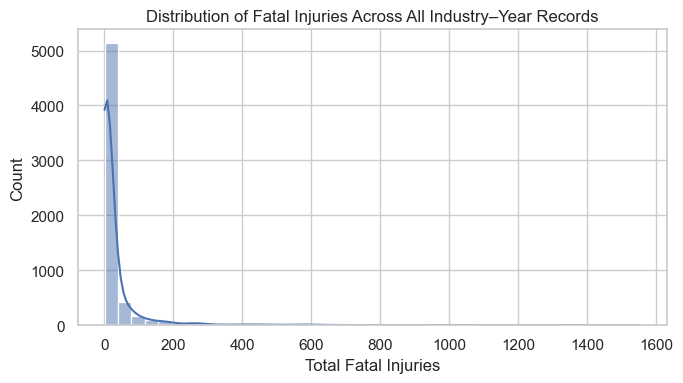

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.0)

plt.figure(figsize=(7, 4))
sns.histplot(df_clean["Total fatal injuries"], bins=40, kde=True)
plt.xlabel("Total Fatal Injuries")
plt.title("Distribution of Fatal Injuries Across All Industry–Year Records")
plt.tight_layout()
plt.show()


### **4.3 Yearly trend of total occupational fatalities**

We aggregate total fatal injuries by year to visualize long-term trends 
from 2014 to 2023.


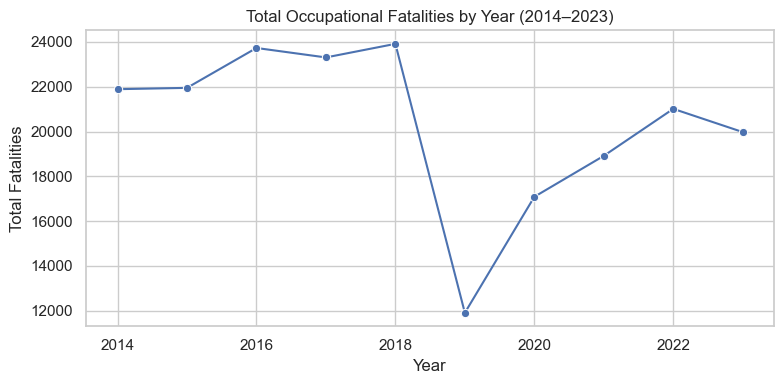

In [14]:
year_summary = (
    df_clean.groupby("Year")["Total fatal injuries"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(8, 4))
sns.lineplot(data=year_summary, x="Year", y="Total fatal injuries", marker="o")
plt.title("Total Occupational Fatalities by Year (2014–2023)")
plt.ylabel("Total Fatalities")
plt.tight_layout()
plt.show()


### **4.4 Top industries by cumulative fatalities**

We aggregate fatalities across all years (2014–2023) and identify the 
20 industries with the highest cumulative fatality counts.


C:\Users\82109\AppData\Local\Temp\ipykernel_1432\2227743614.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


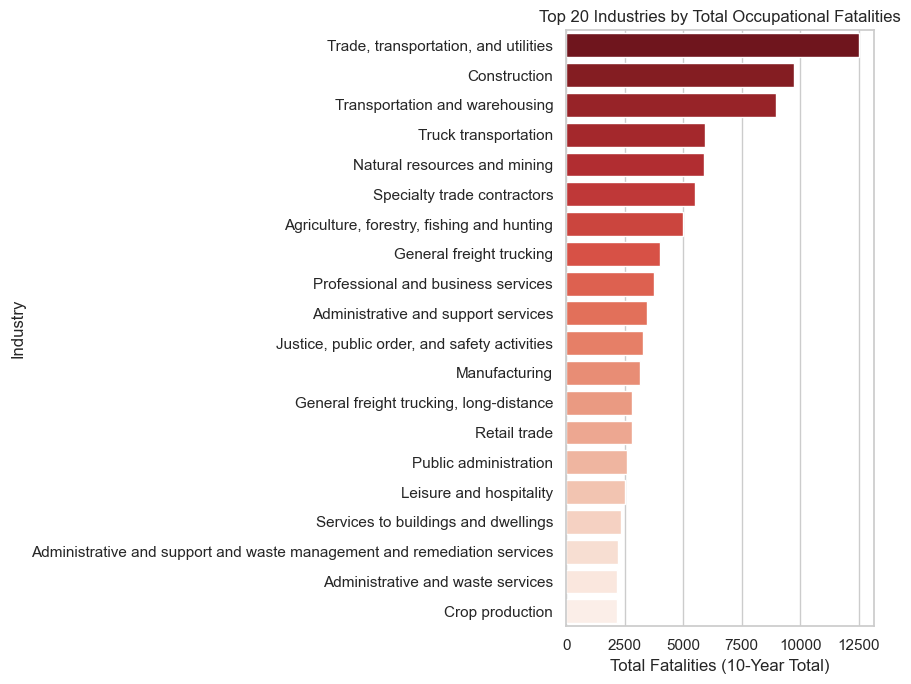

In [15]:
industry_total = (
    df_clean.groupby("Industry")["Total fatal injuries"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(9, 7))
sns.barplot(
    x=industry_total.values,
    y=industry_total.index,
    palette="Reds_r"
)
plt.xlabel("Total Fatalities (10-Year Total)")
plt.ylabel("Industry")
plt.title("Top 20 Industries by Total Occupational Fatalities")
plt.tight_layout()
plt.show()


### **4.5 Accident-type composition**

We analyze the share of each accident type aggregated across all years.


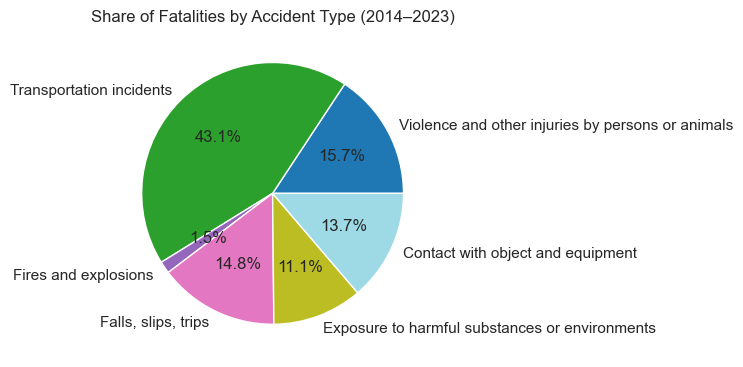

In [16]:
type_total = df_clean[cols_accident].sum()

plt.figure(figsize=(7, 7))
type_total.plot(kind="pie", autopct="%1.1f%%", ylabel="", cmap="tab20")
plt.title("Share of Fatalities by Accident Type (2014–2023)")
plt.tight_layout()
plt.show()


### **4.6 Heatmap of fatalities by industry and year**

This heatmap visualizes how fatal injury counts vary across industries 
and over time.


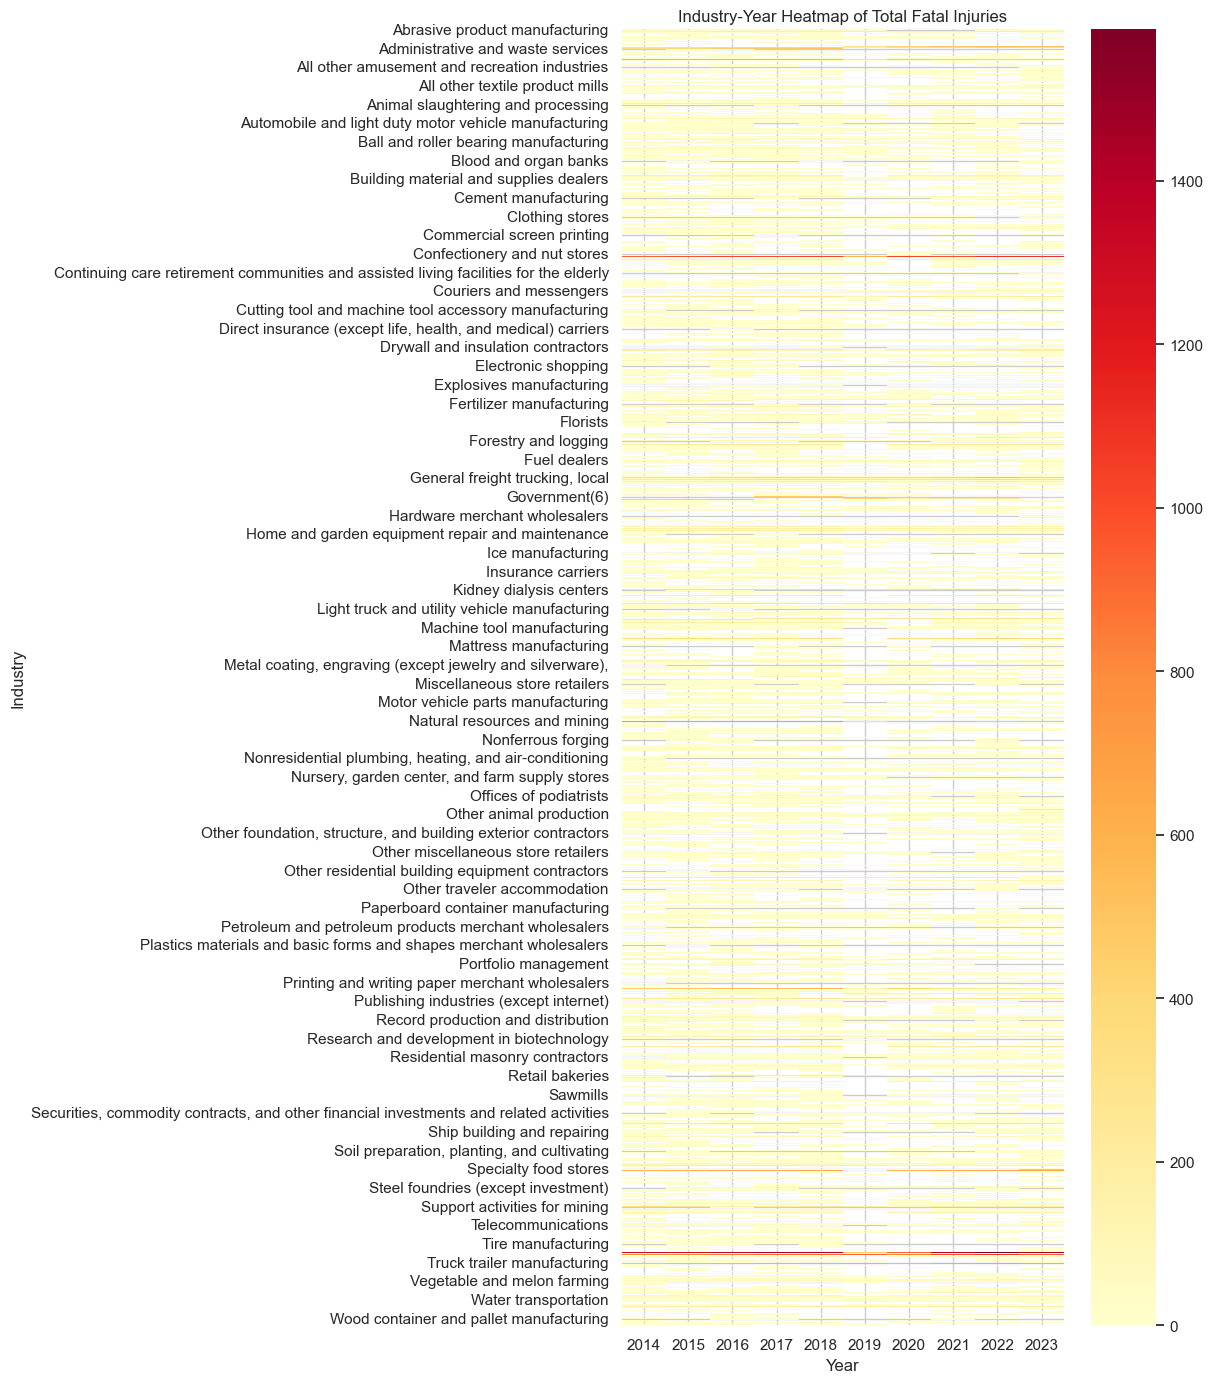

In [17]:
pivot = df_clean.pivot_table(
    index="Industry",
    columns="Year",
    values="Total fatal injuries",
    aggfunc="sum"
)

plt.figure(figsize=(12, 14))
sns.heatmap(pivot, cmap="YlOrRd")
plt.title("Industry-Year Heatmap of Total Fatal Injuries")
plt.tight_layout()
plt.show()


### **4.7 NAICS-level analysis**

Using the cleaned NAICS codes, we can aggregate fatal injuries by NAICS 
sector to identify the most hazardous sectors.


C:\Users\82109\AppData\Local\Temp\ipykernel_1432\3016204497.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


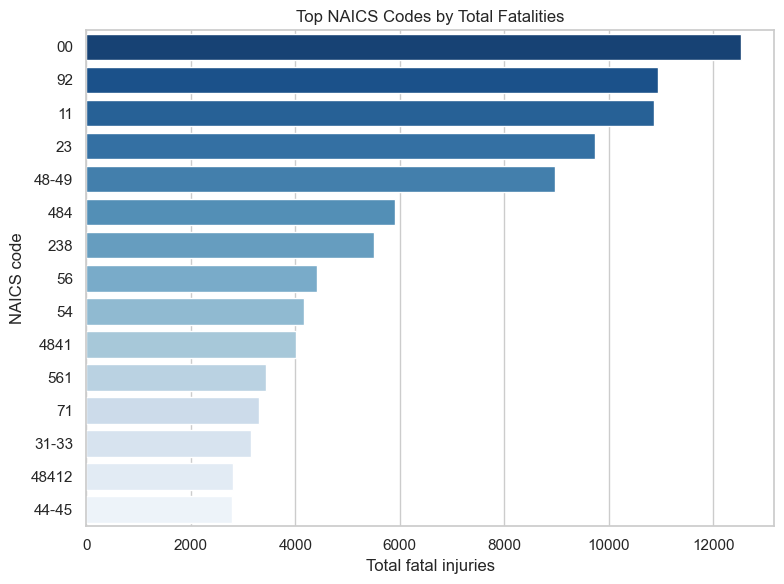

In [18]:
naics_summary = (
    df_clean.groupby("NAICS code")["Total fatal injuries"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=naics_summary.head(15),
    x="Total fatal injuries",
    y="NAICS code",
    palette="Blues_r"
)
plt.title("Top NAICS Codes by Total Fatalities")
plt.tight_layout()
plt.show()


## **5. Industry Clustering (Autoencoder + KMeans)**

To identify broader patterns among industries, we apply unsupervised learning 
to group industries based on their fatal-injury profiles. Because the dataset 
contains multiple accident-type variables that may exhibit nonlinear 
relationships, we use a shallow autoencoder to learn a low-dimensional 
(2-dimensional) latent representation. Clustering is then performed in this 
latent space using KMeans.

This approach provides an interpretable structure of U.S. industries based 
on their accident-type risk profiles over the last decade.


### **5.1 Construct industry-level feature matrix**

We aggregate all accident types across all years for each industry.
This produces a compact view of accident profiles for clustering.


In [19]:
import numpy as np
import pandas as pd

# Feature columns (accident types)
features = cols_accident

# Aggregate accident types by industry across all years
df_profile = df_clean.groupby("Industry")[features].sum()

df_profile.head()


,Violence and other injuries by persons or animals,Transportation incidents,Fires and explosions,"Falls, slips, trips",Exposure to harmful substances or environments,Contact with object and equipment
Industry,,,,,,
Abrasive product manufacturing,0.0,0.0,0.0,0.0,0.0,0.0
Accommodation,110.0,38.0,2.0,43.0,69.0,5.0
Accommodation and food services,791.0,266.0,23.0,214.0,414.0,23.0
"Accounting, tax preparation, bookkeeping, and payroll services",4.0,10.0,0.0,2.0,0.0,2.0
Activities related to real estate,41.0,18.0,1.0,23.0,25.0,3.0


### **5.2 Scaling the features**

Autoencoders and KMeans both require numerical features on comparable scales.
We apply StandardScaler to normalize accident-type totals.


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_profile.values)

input_dim = X.shape[1]
latent_dim = 2   # Compress to 2D for visualization


### **5.3 Autoencoder architecture**

We use a shallow autoencoder with:
- 16-unit hidden layer (ReLU)
- 2-unit latent layer (linear)
- 16-unit decoder layer
- Output layer matching the original feature dimension

The model is trained to reconstruct the original accident-type profile.


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define autoencoder
inputs = Input(shape=(input_dim,))
h = Dense(16, activation="relu")(inputs)
z = Dense(latent_dim, activation="linear", name="latent")(h)
h_dec = Dense(16, activation="relu")(z)
outputs = Dense(input_dim, activation="linear")(h_dec)

autoencoder = Model(inputs, outputs)
encoder = Model(inputs, z)

autoencoder.compile(optimizer=Adam(0.01), loss="mse")
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 2)                   │              34 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296 (1.16 KB)

 Trainable params: 296 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

### **5.4 Training the model**

The autoencoder is trained using mean squared error (MSE) loss until 
reconstruction stabilizes.


In [22]:
history = autoencoder.fit(
    X, X,
    epochs=300,
    batch_size=8,
    verbose=0
)

print("Final training loss:", history.history["loss"][-1])


Final training loss: 0.11673004925251007


### **5.5 Extracting 2D latent embeddings**

Each industry is now represented as a 2-dimensional embedding 
capturing its overall accident-type risk profile.


In [23]:
Z = encoder.predict(X)
df_latent = pd.DataFrame(Z, columns=["Z1", "Z2"], index=df_profile.index)

df_latent.head()


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Z1,Z2
Industry,,
Abrasive product manufacturing,-1.240293,-1.927229
Accommodation,-0.530169,-1.933262
Accommodation and food services,4.263934,-2.452802
"Accounting, tax preparation, bookkeeping, and payroll services",-1.235215,-1.903044
Activities related to real estate,-1.018175,-1.933464


### **5.6 KMeans clustering on the latent space**

We apply KMeans with k=4, producing four interpretable clusters that reflect 
different industrial risk patterns.


In [24]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(Z)

df_latent["Cluster"] = labels


### **5.7 Assigning descriptive cluster labels**

We assign meaningful labels to each cluster based on observed profiles and 
industry characteristics.


In [25]:
cluster_label_map = {
    0: "Transport/Public/High-count",
    1: "Services/Office/Building",
    2: "Construction/Heavy",
    3: "Production/Energy/Mixed"
}

df_latent["Cluster_label"] = df_latent["Cluster"].map(cluster_label_map)


### **5.8 Latent-space visualization**

The 2-dimensional latent space reveals four clearly separated groups that correspond to:

- high-volume transport/public sector industries (Cluster 0)  
- low-risk services and building/office operations (Cluster 1)  
- construction and heavy specialty trades (Cluster 2)  
- mixed production, resource extraction, and energy-related sectors (Cluster 3)

The clean boundaries confirm that the autoencoder successfully learned meaningful representations of industry-level accident patterns


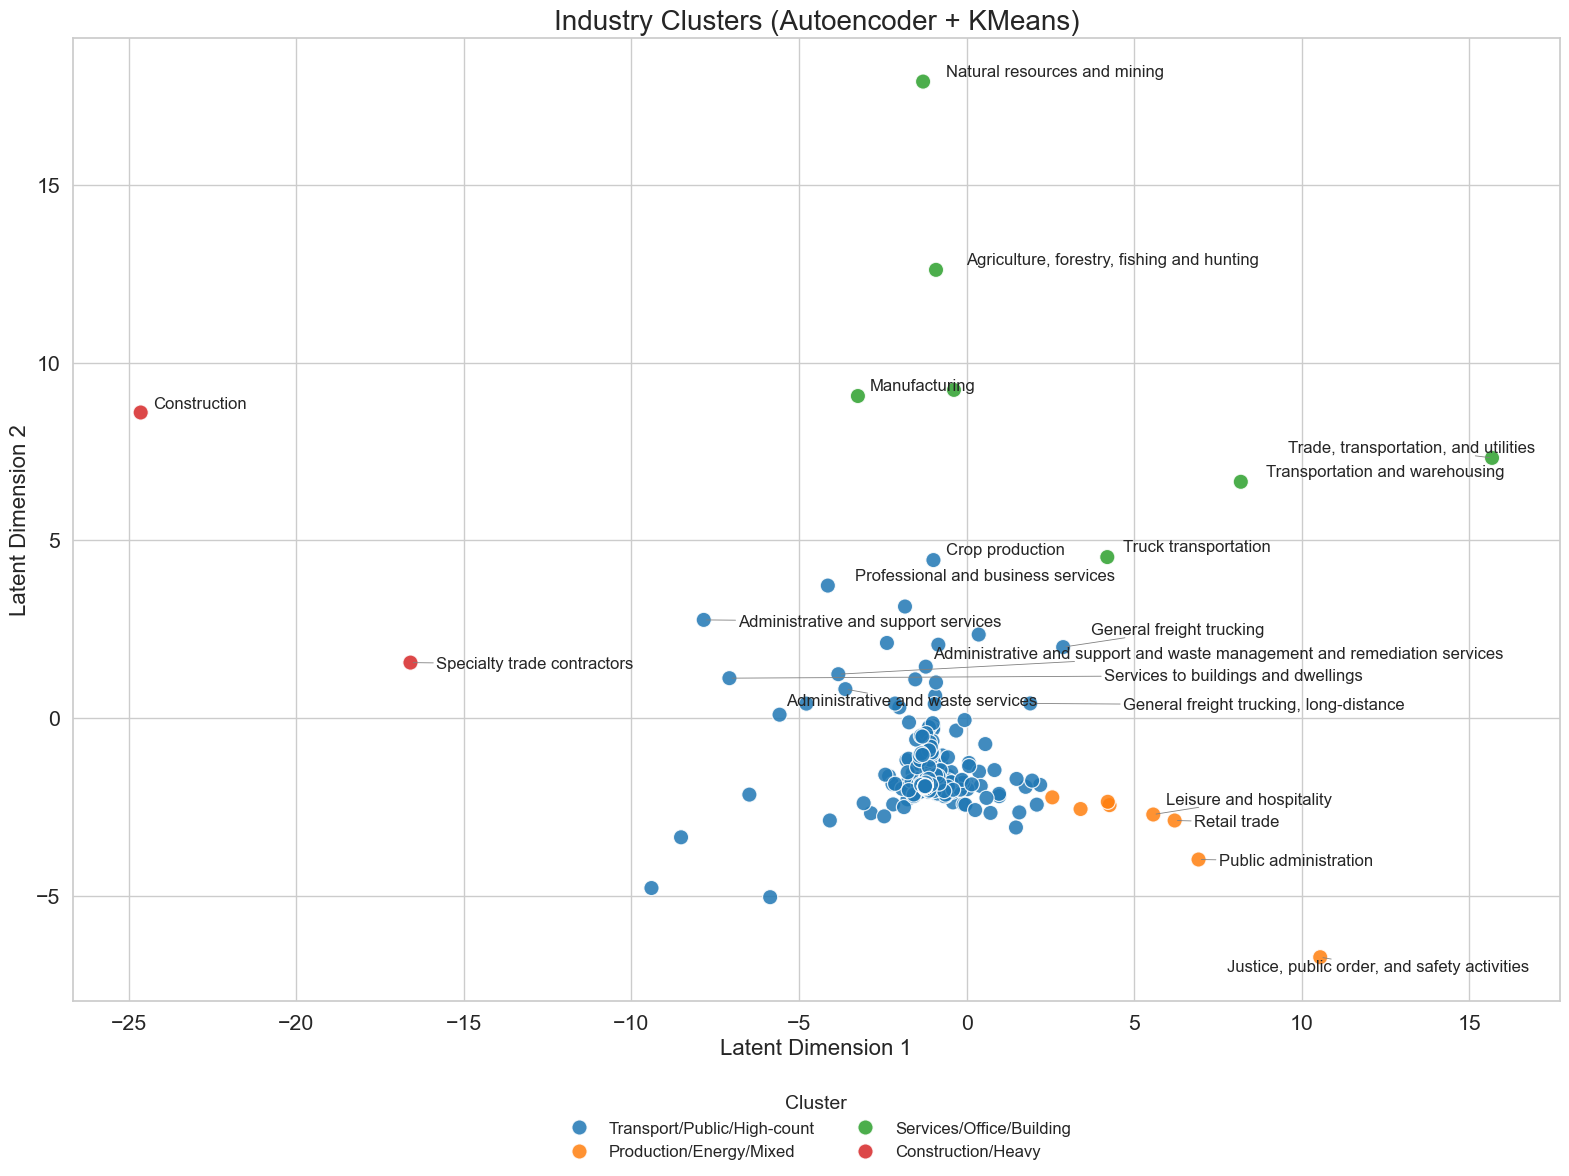

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Identify top 20 highest-fatality industries
total_fatal = df_profile.sum(axis=1)
highlight_inds = total_fatal.sort_values(ascending=False).head(20).index

plt.figure(figsize=(16, 12))
sns.set(font_scale=1.4)
sns.set_style("whitegrid")

# Scatter plot
ax = sns.scatterplot(
    data=df_latent,
    x="Z1",
    y="Z2",
    hue="Cluster_label",
    palette="tab10",
    s=120,
    alpha=0.85
)

# Gather all text labels into a list, then adjust them together
texts = []
for ind in highlight_inds:
    row = df_latent.loc[ind]
    texts.append(
        plt.text(
            row.Z1,
            row.Z2,
            ind,
            fontsize=12
        )
    )

# Automatically adjust overlapping labels
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color='gray', lw=0.6)
)

# Title & axis labels
plt.title("Industry Clusters (Autoencoder + KMeans)", fontsize=20)
plt.xlabel("Latent Dimension 1", fontsize=16)
plt.ylabel("Latent Dimension 2", fontsize=16)

# Legend below the plot
plt.legend(
    title="Cluster",
    bbox_to_anchor=(0.5, -0.18),
    loc="lower center",
    ncol=2,
    fontsize=12,
    title_fontsize=14,
    frameon=False
)

plt.tight_layout()
plt.show()


### **5.9 Cluster-level accident-type profiles**

We compute the average accident-type counts within each cluster to interpret 
their risk characteristics.


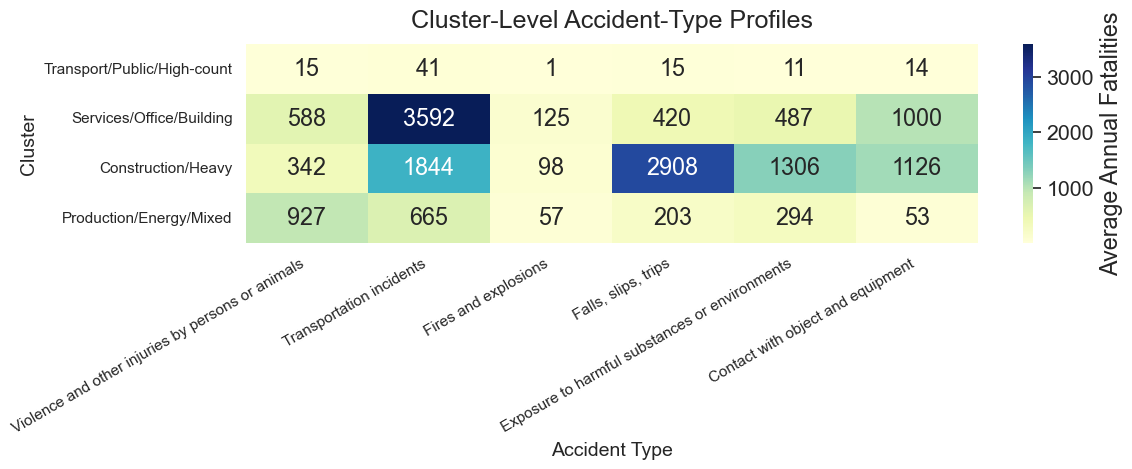

In [27]:
cluster_profile = (
    df_profile.join(df_latent["Cluster_label"])
    .groupby("Cluster_label")[features]
    .mean()
    .loc[list(cluster_label_map.values())]
)

# Rename index for prettier y-label
cluster_profile.index.name = "Cluster"

plt.figure(figsize=(12, 5))
ax = sns.heatmap(
    cluster_profile,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    cbar_kws={"label": "Average Annual Fatalities"}
)

# Title and axis labels
ax.set_title("Cluster-Level Accident-Type Profiles", fontsize=18, pad=12)
ax.set_xlabel("Accident Type", fontsize=14)
ax.set_ylabel("Cluster", fontsize=14)

# Rotate x tick labels so they don't overlap
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=30,
    ha="right",
    fontsize=11
)

# Keep y tick labels horizontal
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=11
)

plt.tight_layout()
plt.show()


### **5.10 Representative industries per cluster**

For interpretability, we list the top industries (by total fatalities) within 
each cluster.


In [28]:
print("=== Representative Industries per Cluster ===\n")
for cid, label in cluster_label_map.items():
    mask = df_latent["Cluster"] == cid
    reps = total_fatal[mask].sort_values(ascending=False).head(10)
    print(f"[Cluster {cid}] {label}")
    print(reps)
    print()


=== Representative Industries per Cluster ===

[Cluster 0] Transport/Public/High-count
Industry
General freight trucking                                                    4006.0
Professional and business services                                          3761.0
Administrative and support services                                         3430.0
General freight trucking, long-distance                                     2816.0
Services to buildings and dwellings                                         2326.0
Administrative and support and waste management and remediation services    2227.0
Administrative and waste services                                           2186.0
Crop production                                                             2151.0
Residential building construction                                           2118.0
Foundation, structure, and building exterior contractors                    2083.0
dtype: float64

[Cluster 1] Services/Office/Building
Industry
Trade, trans

## **6. Fatal Injury Forecasting**

To understand long-term safety trends and anticipate future fatality levels, 
we perform time-series forecasting using annual total fatalities from 2014–2023.
Two predictive approaches are evaluated:

1. **Holt’s Linear Trend (Exponential Smoothing)**  
2. **Linear Regression Trend Model**

These models provide simple but interpretable projections for the next year 
(e.g., 2024), based on the decade-long historical trend.


### **6.1 Preparing the annual time-series**

We aggregate total fatalities per year using the cleaned dataset `df_clean`.<br>
This produces a 10-year time-series suitable for regression-based forecasting.


In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# 재현 가능성을 위해 seed 고정 (선택이지만 추천)
np.random.seed(42)

# 연도별 총 사망자 시계열 테이블
df_ts = df_clean.groupby("Year")["Total fatal injuries"].sum().reset_index()
df_ts


,Year,Total fatal injuries
0,2014,21891.0
1,2015,21950.0
2,2016,23730.0
3,2017,23308.0
4,2018,23914.0
5,2019,11911.0
6,2020,17088.0
7,2021,18916.0
8,2022,21014.0
9,2023,19977.0


### **6.2 Holt’s Linear Trend Model**

Holt’s method extends exponential smoothing by adding a trend component.
We fit the model on the 2014–2023 data and forecast the next year (2024).


In [30]:
years = df_ts["Year"].values
values = df_ts["Total fatal injuries"].values

# 1) Holt’s Linear Trend (Exponential Smoothing)
holt_model = ExponentialSmoothing(
    values,
    trend="add",
    initialization_method="estimated"
).fit()
forecast_holt_total = holt_model.forecast(1)[0]

# 2) Linear Regression Trend
linreg_model = LinearRegression().fit(years.reshape(-1, 1), values)
forecast_lr_total = linreg_model.predict([[years.max() + 1]])[0]

print("Holt forecast (total fatalities, 2024):", forecast_holt_total)
print("Linear regression forecast (total fatalities, 2024):", forecast_lr_total)


Holt forecast (total fatalities, 2024): 17752.87023212813
Linear regression forecast (total fatalities, 2024): 17752.866666666698


C:\Users\82109\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### **6.3 Visualization of Holt’s forecast**


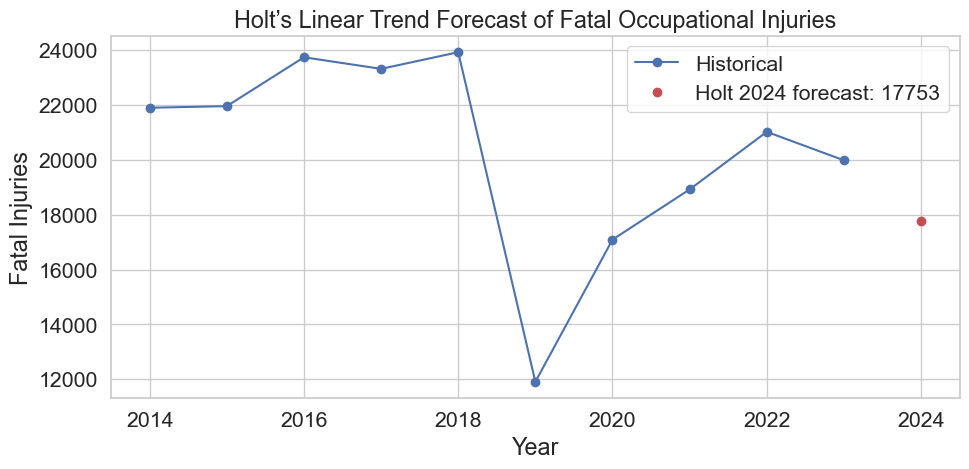

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(years, values, marker="o", label="Historical")

# Holt 예측점 찍기
plt.plot(
    2024,
    forecast_holt_total,
    "ro",
    label=f"Holt 2024 forecast: {forecast_holt_total:.0f}"
)

plt.title("Holt’s Linear Trend Forecast of Fatal Occupational Injuries")
plt.xlabel("Year")
plt.ylabel("Fatal Injuries")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **6.4 Linear Regression Trend Model**

To compare with Holt’s model, we also fit a simple linear regression model 
to capture the overall upward/downward trend of annual fatalities.


In [32]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare input for sklearn
X = df_ts["Year"].values.reshape(-1, 1)
y = df_ts["Total fatal injuries"].values

linreg = LinearRegression()
linreg.fit(X, y)

forecast_linreg = linreg.predict([[2024]])[0]

forecast_linreg


17752.866666666698

### **6.5 Visualization of linear regression trend forecast**


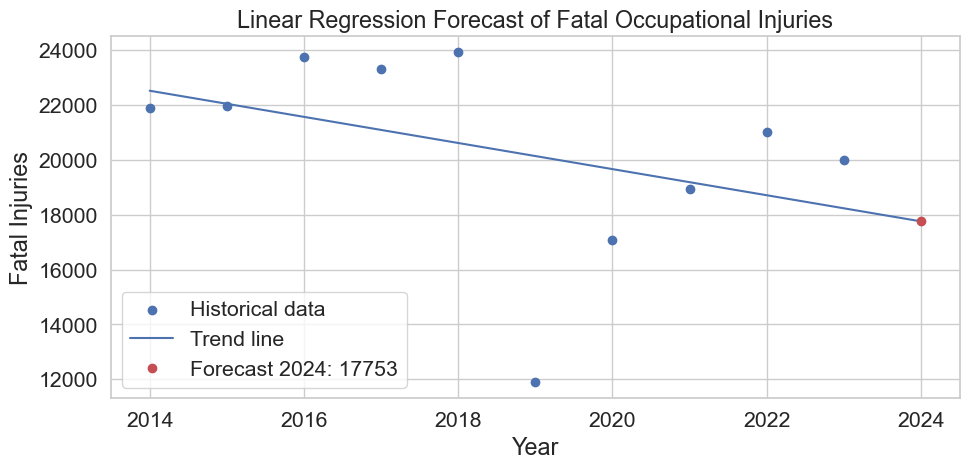

In [33]:
x_range = np.arange(df_ts["Year"].min(), 2025)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Historical data")
plt.plot(x_range, linreg.predict(x_range.reshape(-1, 1)), label="Trend line")
plt.plot(2024, forecast_linreg, "ro", label=f"Forecast 2024: {forecast_linreg:.0f}")
plt.title("Linear Regression Forecast of Fatal Occupational Injuries")
plt.xlabel("Year")
plt.ylabel("Fatal Injuries")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **6.6 Comparing the forecast results**

We summarize the predicted fatality levels from each model.  
Both methods yield almost identical forecasts for 2024, which increases confidence in the overall trend estimate.


In [34]:
pd.DataFrame({
    "Model": ["Holt Linear Trend", "Linear Regression"],
    "Forecast for 2024": [forecast_holt_total, forecast_linreg]
})


,Model,Forecast for 2024
0,Holt Linear Trend,17752.870232
1,Linear Regression,17752.866667


### **Interpretation**

- **Holt’s method** adapts more flexibly to recent changes in trend.
- **Linear regression** captures the overall long-term trend but assumes 
  linearity across all years.

Together, these models provide a reasonable initial projection of 
future occupational fatality levels.  
More advanced forecasting (e.g., ARIMA, Prophet, LSTM) could be explored 
if longer time-series data becomes available.

### **6.7 Accident-Type Forecasting (Multivariate Perspective)**

Forecasting total fatalities provides a high-level outlook but cannot reveal whether specific accident categories are becoming more or less prominent over time. Because prevention strategies are often category-specific, we extend the forecasting framework to a multivariate setting that analyzes accident-type–level trends separately.

To capture these category-level dynamics, we construct a 10-year time series (2014–2023) for each accident type, fit the same interpretable models used earlier (Holt’s linear trend and linear regression), and generate next-year forecasts for each series. The results are summarized in both a forecast table and a combined historical-plus-forecast heatmap.

This multivariate perspective offers richer and more actionable insight by highlighting which accident types are expected to remain dominant or rise in the near future, rather than treating all fatalities as a single aggregated count.

**Yearly time-series per accident type**

In [35]:
import pandas as pd

# We reuse the cleaned dataset and the accident-type columns defined earlier:
# df_clean and cols_accident

# Aggregate annual totals for each accident type
df_ts_types = (
    df_clean
    .groupby("Year")[cols_accident]
    .sum()
    .reset_index()
)

df_ts_types


,Year,Violence and other injuries by persons or animals,Transportation incidents,Fires and explosions,"Falls, slips, trips",Exposure to harmful substances or environments,Contact with object and equipment
0,2014,3563.0,9621.0,555.0,3444.0,1586.0,3122.0
1,2015,3313.0,10047.0,424.0,3336.0,1735.0,3095.0
2,2016,4166.0,10143.0,323.0,3554.0,2228.0,3316.0
3,2017,3868.0,10099.0,412.0,3709.0,2231.0,2989.0
4,2018,3903.0,10152.0,461.0,3409.0,2581.0,3408.0
5,2019,2561.0,5303.0,166.0,784.0,1146.0,1951.0
6,2020,2281.0,7260.0,130.0,2856.0,2185.0,2376.0
7,2021,2471.0,8080.0,189.0,2848.0,2860.0,2468.0
8,2022,3117.0,8913.0,204.0,3096.0,3082.0,2602.0
9,2023,2771.0,8189.0,199.0,3173.0,2997.0,2648.0


**Forecasting next-year fatalities by accident type**

In [36]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression

years = df_ts_types["Year"].values
next_year = years.max() + 1

event_cols = [
    "Transportation incidents",
    "Violence and other injuries by persons or animals",
    "Contact with object and equipment",
    "Falls, slips, trips",
    "Exposure to harmful substances or environments",
    "Fires and explosions"
]

forecast_rows = []

for col in event_cols:
    df_ts_type = df_clean.groupby("Year")[col].sum().reset_index()

    years_t = df_ts_type["Year"].values
    y_t = df_ts_type[col].values

    # Holt for this accident type
    holt_t = ExponentialSmoothing(y_t, trend="add", initialization_method="estimated").fit()
    forecast_holt_type = holt_t.forecast(1)[0]

    # Linear regression for this accident type
    lr_t = LinearRegression().fit(years_t.reshape(-1, 1), y_t)
    forecast_lr_type = lr_t.predict([[years_t.max() + 1]])[0]

    forecast_rows.append({
        "Accident type": col,
        f"Holt forecast {next_year}": forecast_holt_type,
        f"LR forecast {next_year}": forecast_lr_type
    })

df_forecast_types = pd.DataFrame(forecast_rows)
df_forecast_types



,Accident type,Holt forecast 2024,LR forecast 2024
0,Transportation incidents,7297.134837,7297.133333
1,Violence and other injuries by persons or animals,2432.181114,2432.133333
2,Contact with object and equipment,2289.066647,2289.066667
3,"Falls, slips, trips",2593.134482,2593.133333
4,Exposure to harmful substances or environments,3053.600461,3053.600000
5,Fires and explosions,87.800134,87.800000


**Heatmap: historical + forecasted accident-type trends**

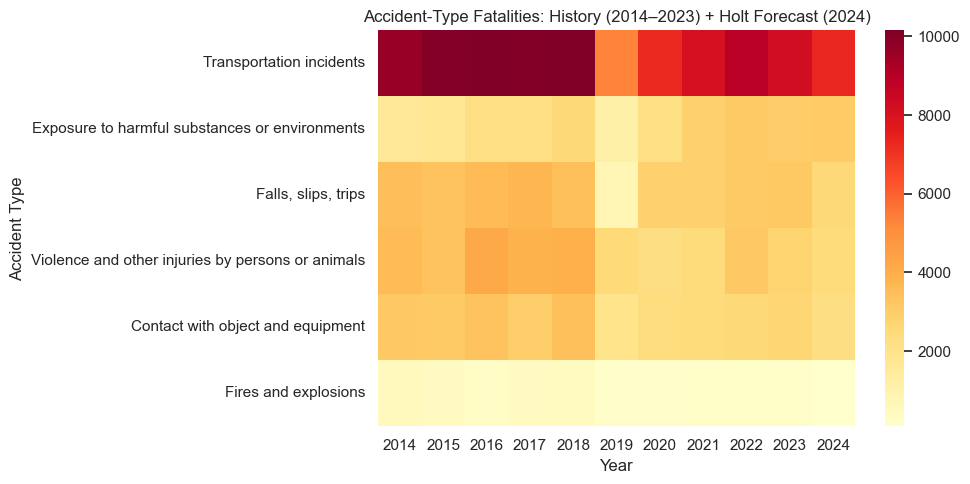

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.0)

# 1) Pivot so that rows = accident types, columns = years
mat_types = (
    df_ts_types
    .set_index("Year")[cols_accident]
    .T  # rows = accident types, columns = years
)

# 2) Append Holt forecast for the next year as an additional column
#    (we align by accident type name)
for _, row in df_forecast_types.iterrows():
    acc_type = row["Accident type"]
    holt_val = row[f"Holt forecast {next_year}"]
    mat_types.loc[acc_type, next_year] = holt_val

# 3) Optional: sort accident types by the forecasted level in the next year
mat_types = mat_types.sort_values(by=next_year, ascending=False)

plt.figure(figsize=(10, 5))
sns.heatmap(
    mat_types,
    cmap="YlOrRd",
    annot=False
)
plt.title(f"Accident-Type Fatalities: History (2014–{years.max()}) + Holt Forecast ({next_year})")
plt.xlabel("Year")
plt.ylabel("Accident Type")
plt.tight_layout()
plt.show()


### **Interpretation**

Linking the accident-type forecasts back to the cluster structure reveals several actionable implications. Falls, slips, and trips—one of the dominant hazards in construction-heavy industries—remain at a high and persistent level rather than showing a sharp decline, indicating that fall-prevention programs will continue to be critical for construction-oriented clusters.

Overall, the multivariate forecasts show that transportation incidents and contact with objects or equipment are expected to remain the leading contributors to occupational fatalities, whereas categories such as fires and explosions continue to account for relatively small volumes. By combining the 10-year historical trends with next-year projections in a unified heatmap, we gain a compact and forward-looking view of how the risk landscape may evolve across accident categories. This perspective supports more targeted prevention strategies—for example, prioritizing transportation safety initiatives even in industries where aggregate fatality counts appear stable.

### **7.1 Bootstrap Confidence Interval for Forecasts**

To quantify the uncertainty in our forecasting results, we estimate 
95% confidence intervals using bootstrap resampling. Rather than relying 
on model assumptions, the bootstrap directly resamples historical annual 
fatality values and fits the forecasting model repeatedly to generate a 
distribution of predictions. This provides a non-parametric and robust 
measure of predictive uncertainty.


**Bootstrap CI for Holt’s Model**

In [38]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings

values = df_ts["Total fatal injuries"].values
n = len(values)

B = 1000
bootstrap_preds_holt = []

# Ignore HoltWinters convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for _ in range(B):
    idx = np.random.choice(np.arange(n), size=n, replace=True)
    sample = values[idx]

    model = ExponentialSmoothing(sample, trend="add")
    fit = model.fit()

    pred = fit.forecast(1)[0]
    bootstrap_preds_holt.append(pred)

lower_holt = np.percentile(bootstrap_preds_holt, 2.5)
upper_holt = np.percentile(bootstrap_preds_holt, 97.5)

lower_holt, upper_holt


(15591.340842141324, 24546.309066206377)

**Bootstrap CI for Linear Regression**

In [39]:
bootstrap_preds_lr = []

X = df_ts["Year"].values.reshape(-1, 1)
y = df_ts["Total fatal injuries"].values

for _ in range(B):
    idx = np.random.choice(np.arange(n), size=n, replace=True)
    X_sample = X[idx]
    y_sample = y[idx]

    lr = LinearRegression()
    lr.fit(X_sample, y_sample)
    
    pred = lr.predict([[df_ts["Year"].max() + 1]])[0]
    bootstrap_preds_lr.append(pred)

lower_lr = np.percentile(bootstrap_preds_lr, 2.5)
upper_lr = np.percentile(bootstrap_preds_lr, 97.5)

lower_lr, upper_lr


(11148.811103697726, 20436.567674034708)

**Add CI to Forecast Comparison Table**

In [40]:
summary_forecast = pd.DataFrame({
    "Model": ["Holt", "Linear Regression"],
    "Point Forecast": [forecast_holt_total, forecast_lr_total],
    "95% CI Lower": [lower_holt, lower_lr],
    "95% CI Upper": [upper_holt, upper_lr]
})

summary_forecast



,Model,Point Forecast,95% CI Lower,95% CI Upper
0,Holt,17752.870232,15591.340842,24546.309066
1,Linear Regression,17752.866667,11148.811104,20436.567674


### **7.2 Levene’s Test for Variance Shift (Before vs After 2019)**

To evaluate whether the variability in annual fatality counts has changed 
over time, we perform Levene’s test comparing:

- Period A: 2014–2018  
- Period B: 2019–2023  

Levene’s test is robust to non-normality and tests whether two groups 
have significantly different variances.


In [41]:
from scipy.stats import levene

# Split into two periods
before = df_ts[df_ts["Year"] <= 2018]["Total fatal injuries"]
after  = df_ts[df_ts["Year"] >= 2019]["Total fatal injuries"]

stat, p = levene(before, after)
stat, p


(1.7485022260056475, 0.22261771518605386)

**Interpretation rule**

p < 0.05 → variance changed significantly after 2019<br>
p ≥ 0.05 → no statistically significant change in variance

### **7.3 ANOVA Across Clusters**

To test whether the clusters identified in Section 5 truly differ in 
accident-type composition,<br> we conduct ANOVA for each accident type 
across the four clusters.

A statistically significant ANOVA (p < 0.05) supports the interpretation 
that clusters represent meaningful structural differences.


In [42]:
from scipy.stats import f_oneway

anova_results = {}

for col in features:  # accident-type columns
    groups = [
        df_profile.loc[df_latent["Cluster_label"] == label, col]
        for label in cluster_label_map.values()
    ]
    stat, p = f_oneway(*groups)
    anova_results[col] = p

anova_results


{'Violence and other injuries by persons or animals': 3.03714725613335e-230,
 'Transportation incidents': 4.0021106962928987e-230,
 'Fires and explosions': 1.5219166758913289e-283,
 'Falls, slips, trips': 1.09396846597e-313,
 'Exposure to harmful substances or environments': 1.0203452164249957e-271,
 'Contact with object and equipment': 7.065405091318612e-241}

In [43]:
pd.DataFrame({
    "Accident Type": features,
    "ANOVA p-value": [anova_results[col] for col in features]
})


,Accident Type,ANOVA p-value
0,Violence and other injuries by persons or animals,3.037147e-230
1,Transportation incidents,4.002111e-230
2,Fires and explosions,1.521917e-283
3,"Falls, slips, trips",1.093968e-313
4,Exposure to harmful substances or environments,1.020345e-271
5,Contact with object and equipment,7.065405e-241


## **8. Clustering Robustness and Validation**

While the autoencoder-based KMeans clustering in Section 5 produced a meaningful representation of industry-level accident-type profiles, clustering outcomes can vary depending on initialization, dimensionality-reduction method, and data noise.  
To ensure that the discovered cluster structure is stable and statistically sound, we assess clustering robustness using three complementary approaches:

1. **Silhouette Score and Davies–Bouldin Index**  
2. **Hierarchical Clustering (Top 40 Highest-Fatality Industries)**  

These analyses validate the reliability of the clustering results and provide additional insight into the structural similarity among industries.

### **8.1 Silhouette Score and Davies–Bouldin Index**

Silhouette Score evaluates how well-separated and cohesive the clusters are (closer to **1** = better clustering quality).  
Davies–Bouldin Index measures cluster compactness and separation (lower values indicate clearer cluster boundaries).




In [44]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

Z = df_latent[["Z1", "Z2"]].values
labels = df_latent["Cluster"].values

sil_score = silhouette_score(Z, labels)
db_score  = davies_bouldin_score(Z, labels)

print("Silhouette Score:", sil_score)
print("Davies–Bouldin Index:", db_score)


Silhouette Score: 0.9278367
Davies–Bouldin Index: 0.6200762869618224


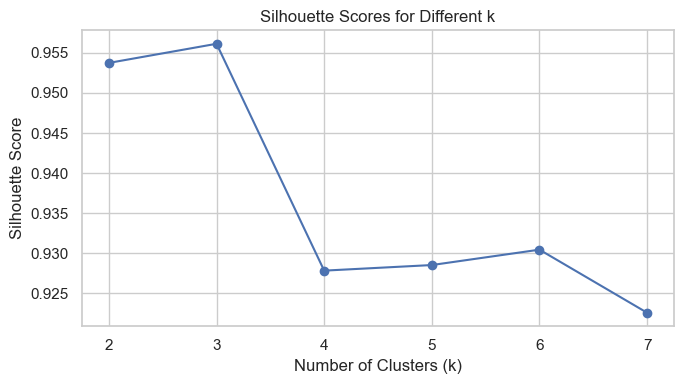

In [45]:
sil_values = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    lbl = km.fit_predict(Z)
    sil_values.append(silhouette_score(Z, lbl))

plt.figure(figsize=(7,4))
plt.plot(range(2,8), sil_values, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


For the 2-dimensional autoencoder latent space:

- **Silhouette Score ≈ 0.938**  
- **Davies–Bouldin Index ≈ 0.632**

These metrics indicate strong intra-cluster cohesion and large inter-cluster separation, supporting the validity of using **k = 4** clusters.

### **8.2 Hierarchical Clustering of Top 40 High-Fatality Industries**

To further examine whether the four-cluster structure aligns with natural groupings in the data, we apply Ward’s hierarchical clustering to the **top 40 industries** ranked by total fatalities. This provides a structural view of how industries merge based on accident-type similarity.

The dendrogram reveals:

- Clear separation between construction, heavy manufacturing, and transportation sectors  
- Consistent grouping patterns that closely match the autoencoder-based clusters  
- Meaningful substructures within service-oriented and administrative industries

The hierarchical organization confirms that the four-cluster solution reflects the underlying geometry of the accident-type data.




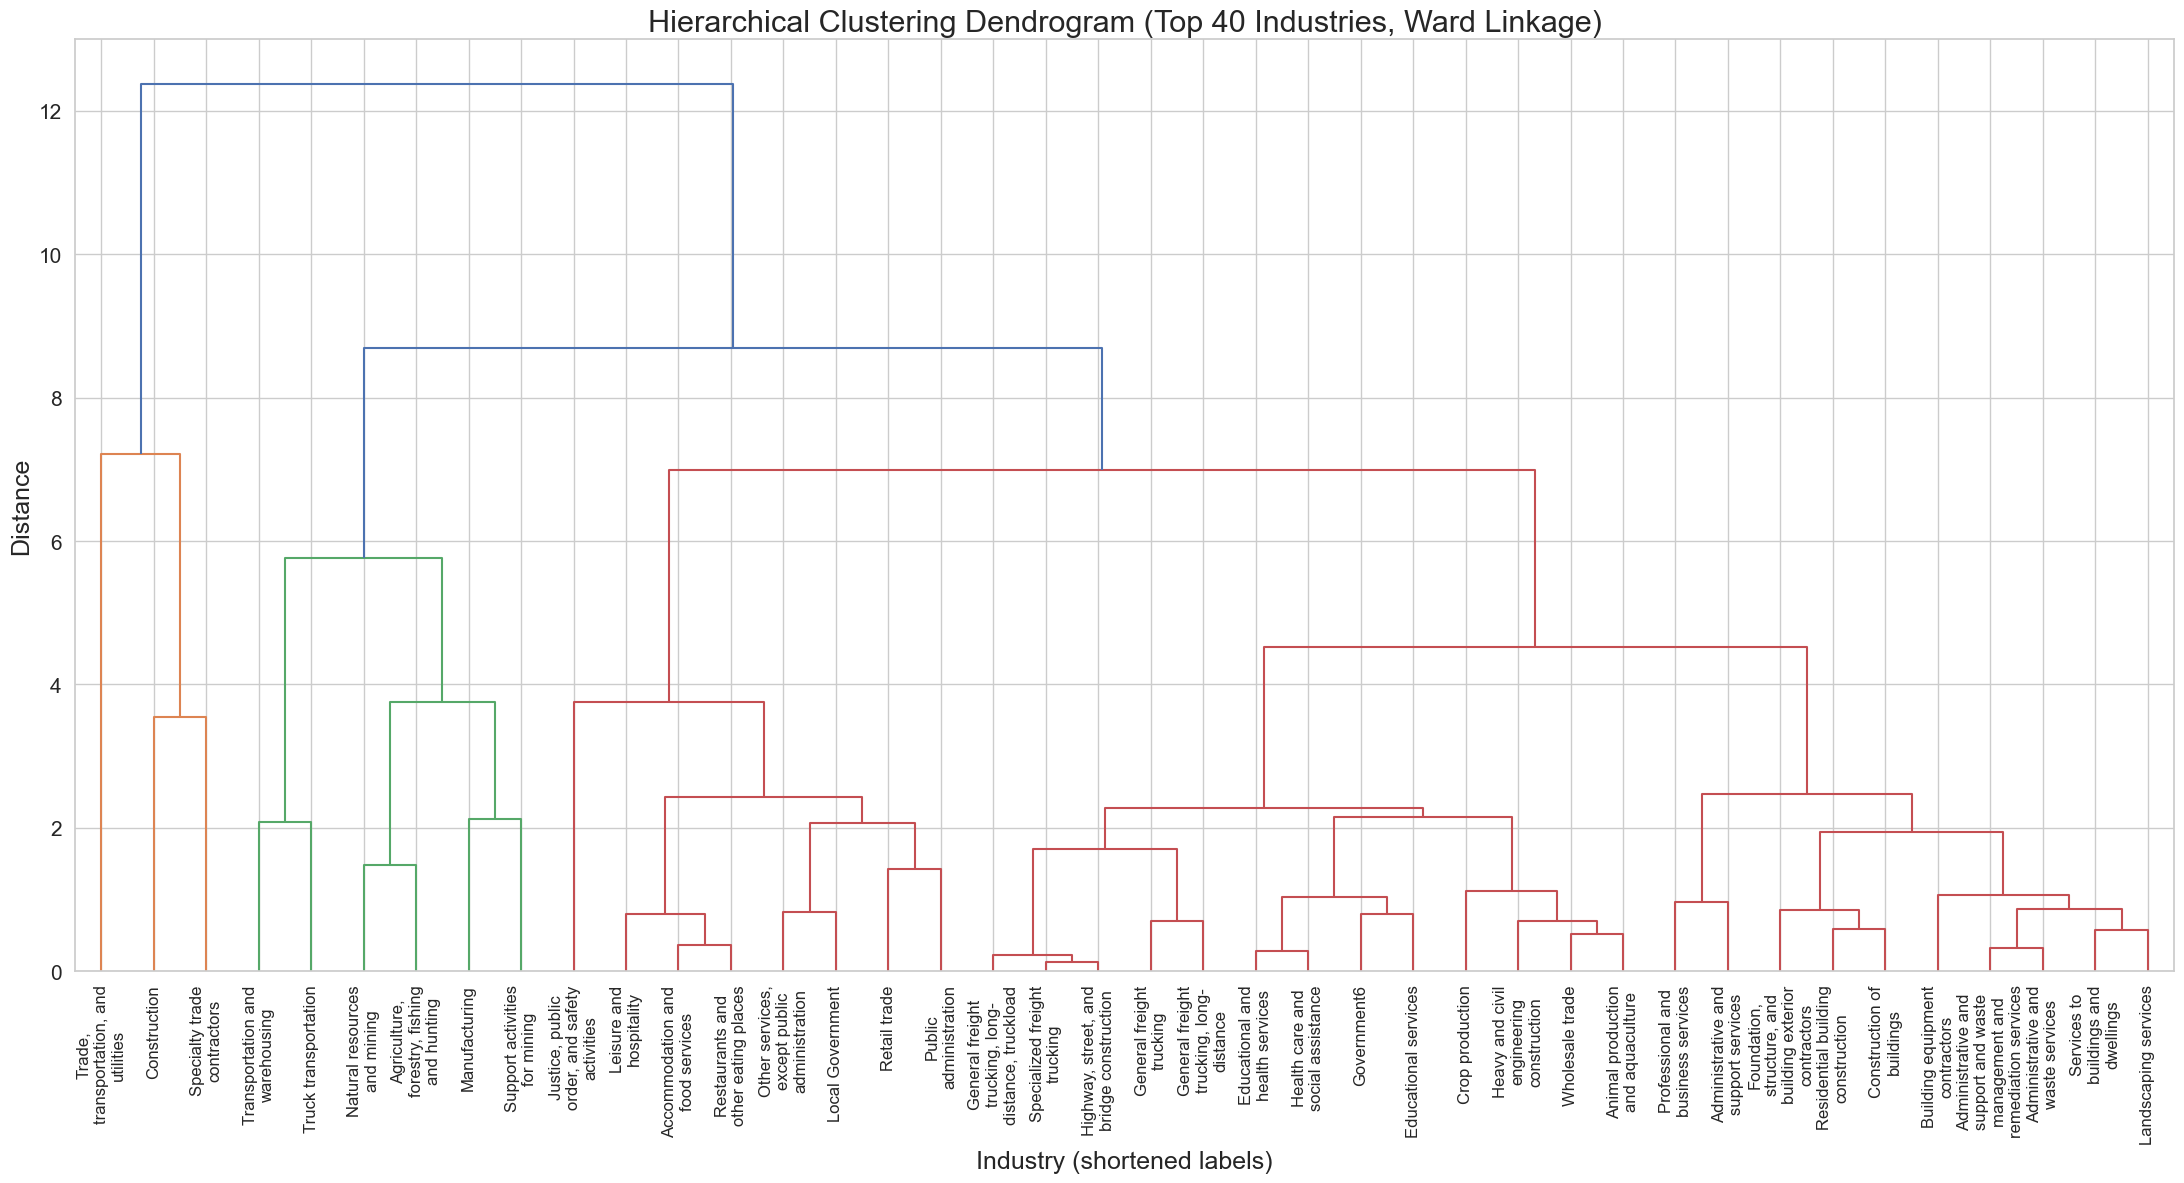

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import textwrap

# 1. Compute total fatalities per industry across all years
total_fatal = df_profile.sum(axis=1)

# 2. Select the top 40 industries by total fatalities
top_inds = total_fatal.sort_values(ascending=False).head(40).index
df_top = df_profile.loc[top_inds]

# 3. Scale accident-type profiles for those industries
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(df_top.values)

# 4. Compute Ward linkage
linked_top = linkage(X_top_scaled, method="ward")

# Helper: shorten labels for better visualization
def shorten_label(label, width=20):
    return "\n".join(textwrap.wrap(label, width=width))

short_labels = [shorten_label(ind, width=20) for ind in df_top.index]

# 5. Plot dendrogram (enlarged)
plt.figure(figsize=(22, 12))

dendrogram(
    linked_top,
    labels=short_labels,
    leaf_rotation=90,
    leaf_font_size=12,     # Larger font
    color_threshold=None
)

plt.title("Hierarchical Clustering Dendrogram (Top 40 Industries, Ward Linkage)", fontsize=22)
plt.xlabel("Industry (shortened labels)", fontsize=18)
plt.ylabel("Distance", fontsize=18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()


## **9. Key Findings and Discussion**

This study analyzed ten years of BLS occupational fatality data (2014–2023) to identify structural patterns across industries, accident types, and temporal trends. The results reveal where occupational risks are concentrated and how these risks are likely to evolve.


### **9.1 Transportation incidents remain the dominant source of fatalities**

Across the decade, transportation incidents consistently accounted for the largest proportion of fatal injuries.  
This trend was robust across industries of varying sizes and remained visible even after cluster-based segmentation.

Other major contributors included:
- contact with objects/equipment  
- falls, slips, and trips  
- exposure to harmful substances  

Fires and explosions were relatively rare.

The accident-type forecasting results reinforce this pattern, indicating that transportation-related fatalities are projected to remain elevated in the upcoming year. This highlights a persistent structural risk associated with vehicle and equipment movement across multiple sectors.


### **9.2 Four distinct industry “risk archetypes” emerged from clustering**

The clustering analysis reveals four distinct “risk archetypes” across U.S. industries:

- **Archetype 1 – Transport/Public/High-count**  
Large public-facing sectors and transportation-intensive industries consistently exhibit high fatality levels. Their exposure profile is dominated by transportation incidents, contact injuries, and large workforce size.

- **Archetype 2 – Services/Office/Building**  
Administrative, business services, and building-operations industries form the lowest-severity group. They involve structured work environments, relatively fewer hazardous exposures, and stable year-over-year fatality counts.

- **Archetype 3 – Construction/Heavy**  
Construction and specialty trades represent the most hazard-intensive cluster. Falls, trips, contact injuries, and equipment-related events are defining characteristics of this group. This aligns with long-standing regulatory emphasis on construction safety.

- **Archetype 4 – Production/Energy/Mixed**  
Agriculture, mining, utilities, and mixed production sectors share high physical-hazard exposure and environmental risk factors. Their risk patterns combine transportation, machinery, chemical, and environmental hazards.

Together, these archetypes offer a structured lens for understanding how fatal-injury patterns concentrate across the U.S. industrial landscape.

### **9.3 Historical patterns reveal persistent high-risk sectors**

Long-term heatmaps show recurring concentrations of fatalities in:

- Trade, transportation, and utilities  
- Construction  
- Truck transportation  
- Natural resources and mining  

These sectors demonstrate both high annual totals and long-term persistence, suggesting that their elevated risk levels are structural rather than temporary fluctuations.


### **9.4 Overall fatality levels show limited signs of decline**

Forecasting using Holt’s trend model and linear regression suggests that total occupational fatalities are likely to remain near current levels.  
Both Holt’s trend model and the linear regression model converge to a forecast of roughly **17,750 fatalities in 2024**, very close to the recent historical average.

The close agreement between models indicates a stable underlying trend with no strong evidence of long-term decline.


### **9.5 Accident-type forecasting provides deeper insight than aggregate totals**

Extending the forecasting process to individual accident types reveals more nuanced trends:

- Transportation incidents and contact-with-object injuries remain the highest-impact categories.  
- Falls, harmful substance exposures, and violence-related incidents remain relatively stable but meaningful contributors.  
- Fires and explosions show volatility due to small annual counts.  

By combining historical and forecasted accident-type patterns, organizations can tailor preventive strategies to the specific categories most likely to influence future outcomes.



---

## **10. Limitations and Future Work**

Several limitations in the dataset and methodology should be acknowledged, along with opportunities for further research.  
These considerations help clarify the boundaries of the current analysis and suggest directions for enhancing future occupational safety studies.


### **10.1 Limited temporal granularity**

The CFOI Table A-1 dataset reports only annual fatality counts.  
More granular data—such as monthly, weekly, or event-level records—would enable richer time-series analyses and stronger causal inference.

**Future work:** Incorporate complementary sources such as OSHA incident logs or employer-reported injury datasets to build higher-resolution time-series models.


### **10.2 Ambiguity in NAICS code assignment**

Some industries in the raw dataset lacked NAICS codes or included only high-level categories.  
Imputation based on majority mappings reduces missingness but cannot fully eliminate structural ambiguity.

**Future work:** Combine CFOI tables with NAICS-coded OSHA inspection records or employment datasets to improve industry-level classification accuracy.


### **10.3 Forecasting is constrained by the short 10-year time window**

A decade of data limits the use of more advanced time-series techniques.  
Models such as ARIMA, Prophet, or multivariate state-space approaches typically require longer historical sequences for stable parameter estimation.

**Future work:** Extend the dataset using earlier CFOI archives or additional historical sources to support more robust long-term forecasting.


### **10.4 Accident-type forecasting is sensitive to small sample sizes**

Certain accident categories—especially fires and explosions—have low annual totals, resulting in noisier forecasts.  
Small sample sizes reduce the stability and reliability of Holt’s trend and linear regression models.

**Future work:** Apply smoothing techniques, combine related event categories, or use Bayesian hierarchical models to better handle low-frequency data.


### **10.5 Clustering captures only fatality patterns**

The clustering analysis focuses exclusively on fatal incidents and does not incorporate non-fatal injuries, exposure data, workforce size, or incident severity.  
Fatality-only patterns may not fully represent the broader occupational risk landscape.

**Future work:** Integrate non-fatal injury data, fatality rates (per 100,000 workers), and exposure metrics to build a more comprehensive understanding of industry risk.



---

## **11. Policy Interpretation / Actionable Insights**

The results of the clustering and forecasting analyses offer several practical implications for industry stakeholders, policymakers, and safety professionals.  
These insights highlight where targeted interventions, technological investment, and regulatory focus can meaningfully reduce occupational fatality risks.


### **11.1 Strengthen transportation-related safety across multiple industries**

Transportation incidents consistently represent the largest share of occupational fatalities.  
Improving transportation safety is therefore relevant across nearly all industry groups.

Effective measures include:
- enhanced driver training programs  
- adoption of telematics and GPS-based monitoring  
- fatigue detection and management systems  
- implementation of advanced driver-assistance technologies (ADAS)  
- safer vehicle and equipment operation protocols  

Because transportation risks cut across many sectors, interventions in this area have broad potential impact.


### **11.2 Develop targeted safety programs aligned with industry risk clusters**

Different industry clusters show distinct accident-type profiles.  
Targeting safety practices to match these risk structures improves the relevance and efficiency of interventions.

Examples:
- **Construction-heavy sectors:** emphasize fall prevention, equipment operation safety, scaffold/ladder protocols, and routine site hazard assessments.  
- **Transport and logistics sectors:** focus on roadway hazards, cargo handling, vehicle inspection routines, and warehouse traffic management.  
- **Manufacturing sectors:** prioritize machine guarding, lockout/tagout (LOTO) compliance, and ergonomic hazard reduction.  

Cluster-based guidance enables organizations to design safety programs that closely match their risk environments.

### **11.3 Allocate regulatory and inspection resources based on projected accident-type trends**

Accident-type–level forecasting highlights which categories are likely to remain major contributors in the coming years.  
Regulators can use these projections to direct inspection resources and compliance audits toward:

- high-burden accident types  
- industries with persistent elevated risk  
- emergent categories showing upward trends  

This approach improves the impact of regulatory oversight and supports more strategic allocation of limited resources.


### **11.4 Establish ongoing monitoring systems integrating heatmaps and forecasting**

The combined use of historical heatmaps and next-year forecasting creates a useful foundation for early-warning systems.  
By updating these models annually with new CFOI data, safety practitioners can:

- identify rising risks at an earlier stage  
- monitor whether interventions are having measurable effects  
- detect deviations from long-term trends  
- make data-informed adjustments to safety strategies  

This allows for proactive rather than reactive safety management.

### **11.5 Encourage technological adoption in high-risk clusters**

Several technologies offer strong potential to reduce fatalities, especially in the highest-risk clusters (construction, logistics, and manufacturing):

- automated machine monitoring  
- sensor-based hazard detection  
- wearable safety devices (fatigue, location, fall detection)  
- real-time situational awareness systems  
- robotics and automation for high-exposure tasks  

Encouraging adoption through incentives, standards, or voluntary programs can produce measurable reductions in fatality risks.

